<a href="https://colab.research.google.com/github/DrDoaaSh/phd-code/blob/main/comparModels_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import optimizers
from keras import regularizers
import tensorflow as tf
import cv2
from keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from skimage.util.shape import view_as_blocks
from keras.utils import np_utils
from keras.utils import to_categorical


import numpy
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras.layers import Activation
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Concatenate
tf.keras.layers.Concatenate()
from tensorflow.keras.layers import Conv2D,ConvLSTM2D, MaxPooling2D, AveragePooling2D, AveragePooling3D,GlobalAveragePooling3D, GlobalAveragePooling2D, GlobalAveragePooling1D, UpSampling2D, BatchNormalization
from keras.layers.core import Reshape
from keras import optimizers
from tensorflow.keras import regularizers
from keras import Input, Model
from time import time
import time as tm
from keras.initializers import Constant, RandomNormal, glorot_normal
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers import  concatenate

## 30 SRM filters for preprocessing and the activation function

In [ ]:
################################################## 30 SRM FILTERS
srm_weights = np.load('/content/drive/MyDrive/Colab Notebooks/SRM_Kernels.npy')

biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION

T3 = 3
def TLU3(x):
    tlu3 = K.tanh(x)*T3
    return tlu3


T2 = 2
def TLU2(x):
    tlu2 = K.tanh(x)*T2
    return tlu2


def Tanh3(x):
    tlu3 = K.tanh(x)*T3
    return tlu3
###########################################################################

def thtanh(x,t):
    th=K.tanh(x)*t
    return th



from keras.layers import Layer
class Thtanh(Layer):

    def __init__(self, th=1.0, trainable=False, **kwargs):
        super(Thtanh, self).__init__(**kwargs)
        self.supports_masking = True
        self.th = th
        self.trainable = trainable

    def build(self, input_shape):
        self.th_factor = K.variable(self.th,
                                      dtype=K.floatx(),
                                      name='th_factor')

        if self.trainable:
            self._trainable_weights.append(self.th_factor)

        super(Thtanh, self).build(input_shape)

    def call(self, inputs, mask=None):
        return thtanh(inputs, self.th_factor)

    def get_config(self):
        config = {'th': self.get_weights()[0] if self.trainable else self.th,
                  'trainable': self.trainable}
        base_config = super(Thtanh, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

############################################################################

def tlu(x,t):
    tlu = tf.maximum(tf.minimum(x, t), -t)
    return tlu

#from keras.utils.generic_utils import get_custom_objects
#get_custom_objects().update({'tlu': Activation(tlu)})

from keras.layers import Layer
class TLU(Layer):

    def __init__(self, th=1.0, trainable=False, **kwargs):
        super(TLU, self).__init__(**kwargs)
        self.supports_masking = True
        self.th = th
        self.trainable = trainable

    def build(self, input_shape):
        self.th_factor = K.variable(self.th,
                                      dtype=K.floatx(),
                                      name='th_factor')

        if self.trainable:
            self._trainable_weights.append(self.th_factor)

        super(TLU, self).build(input_shape)

    def call(self, inputs, mask=None):
        return tlu(inputs, self.th_factor)

    def get_config(self):
        config = {'th': self.get_weights()[0] if self.trainable else self.th,
                  'trainable': self.trainable}
        base_config = super(TLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

(5, 5, 1, 30)


## TPU

In [ ]:
#https://www.tensorflow.org/guide/tpu
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/tpu.ipynb
#https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=_pQCOmISAQBu

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0
Running on TPU  ['10.74.228.114:8470']


## yedroudj_Net

In [ ]:
##Orginal Code :Strategy to improve the accuracy of convolutional neural network architectures applied to digital image steganalysis in the spatial domain
## https://github.com/BioAITeam/Strategy-to-improve-CNN-applied-to-digital-image-steganalysis-in-the-spatial-domain

def yedroudj_Net():

    img_size= 256
    print ("using",2,"classes")



    # Preprocessing
    inputs = Input(shape=(img_size,img_size,1), name="input_1")
    layers = Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1),padding="same", trainable=False, use_bias=True)(inputs)
    layers = Thtanh(th=3.0, trainable=False)(layers)


    # Block 1

    #Layer 0
    layers = Conv2D(30, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])

    # Block 2

    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(30, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)

    # Block 3

    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)

    # Block 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    # Block 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = GlobalAveragePooling2D(data_format="channels_last")(layers)

    # Block 6
    #Layer 5, FC, Softmax

    # FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)

    # Softmax
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model = Model(inputs = inputs, outputs=predictions)
    # Compile
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)#lrate

    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Yedroud-net model generated")
    return model

In [ ]:
##  yedroudj_Net with LSTM classifier

def yedroudj_Net( ):


    img_size= 256
    print ("using",2,"classes")



    # Preprocessing
    inputs = Input(shape=(img_size,img_size,1), name="input_1")
    layers = Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1),padding="same", trainable=False, use_bias=True)(inputs)
    layers = Thtanh(th=3.0, trainable=False)(layers)


    # Block 1

    #Layer 0
    layers = Conv2D(30, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])

    # Block 2

    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(30, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)

    # Block 3

    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)

    # Block 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    # Block 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])

    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2))(layers)

    layers = Reshape((14*14,384))(layers)

    # LSTM
    layers = LSTM(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)

    #layers = GlobalAveragePooling1D(data_format="channels_last")(layers)
    layers = Flatten(name="flatten")(layers)

    # Softmax
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model = Model(inputs = inputs, outputs=predictions)
    # Compile
    #optimizer = tf.optimizers.RMSprop(lr=0.0001, decay=1e-6)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)#lrate
    optimizer= tf.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Yedroud-net model generated")
    return model

## Ye_Net

In [ ]:
##Orginal Code : Strategy to improve the accuracy of convolutional neural network architectures applied to digital image steganalysis in the spatial domain
## https://github.com/BioAITeam/Strategy-to-improve-CNN-applied-to-digital-image-steganalysis-in-the-spatial-domain
def Ye_Net():

    img_size=256
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    print(inputs.shape)

    #Block 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)
    #layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    #layer1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    print(layers.shape)

    #Block 2

    #layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Concatenate()([layers, layers, layers])
    print(layers.shape)

    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    print(layers.shape)

    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    print(layers.shape)

    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(32, (5,5), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    print(layers.shape)

    #Block 6
    layers = tf.keras.layers.Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)

    layers = tf.keras.layers.Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    predictions = tf.keras.layers.Dense(2,kernel_initializer='glorot_normal', activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    print(predictions.shape)

    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)#lrate
    #Compilator
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print ("Ye-net model 2 generated")
    return model

In [ ]:
##Ye_Net with LSTM
def Ye_Net():

    img_size=256
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")


    #Block 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)



    #Block 2

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Concatenate()([layers, layers, layers])


    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)


    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)


    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(32, (5,5), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)


    #Block 6
    layers = tf.keras.layers.Concatenate()([layers, layers, layers])

    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2))(layers)

    layers = Reshape((58*58,96))(layers)
    # LSTM
    layers = LSTM(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(16,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(8,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)

    #layers = GlobalAveragePooling1D(data_format="channels_last")(layers)
    layers = Flatten(name="flatten")(layers)



    predictions = tf.keras.layers.Dense(2,kernel_initializer='glorot_normal', activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)


    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #Compilator
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print ("Ye-net model 2 generated")
    return model

## Xu_Net

In [ ]:
##Orginal Code :Strategy to improve the accuracy of convolutional neural network architectures applied to digital image steganalysis in the spatial domain
## https://github.com/BioAITeam/Strategy-to-improve-CNN-applied-to-digital-image-steganalysis-in-the-spatial-domain
def Xu_Net():

    img_size= 256

    #tf.reset_default_graph()

    print ("using",2,"classes")

    #Preprocessing
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)



    #Block 1

    #Layer 0
    layers = Conv2D(8, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])

    #Block 2

    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(16, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)

    #Block 3

    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)

    #Block 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    #Block 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = GlobalAveragePooling2D(data_format="channels_last")(layers)

    #Block 6
    #Layer 5, FC, Softmax

    #FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)

    #Softmax
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compile
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)

    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Xunet")
    return model

In [ ]:
##Xu_Net with LSTM
def Xu_Net( ):

    #tf.reset_default_graph()
    #tf.keras.backend.clear_session()
    print ("using",2,"classes")

    img_size=256

    #Preprocessing
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)



    #Block 1

    #Layer 0
    layers = Conv2D(8, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])

    #Block 2

    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(16, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)

    #Block 3

    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)

    #Block 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    #Block 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])

    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)

    # Block 6
    #Layer 5, LSTM , Softmax
    layers = Reshape((16*16,384))(layers)
    # LSTM
    layers = LSTM(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)

    layers = Flatten(name="flatten")(layers)

    #Softmax
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compile

    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Xunet")
    return model


### Zhu_Net

In [ ]:
###Orginal Code: Sensitivity of deep learning applied to spatial image steganalysis
### https://github.com/BioAITeam/Sensitivity-of-deep-learning-applied-to-Spatial-Image-Steganalysis
def Zhu_Net():

    img_size=256
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1),name="input_1")

    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layer1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    #Layer 2
    layer1 = tf.keras.layers.SpatialDropout2D(rate=0.1)(layer1)
    layer23 = tf.keras.layers.SeparableConv2D(30,(3,3),activation="relu",depth_multiplier=3,padding="same")(layer1)
    layer23 = tf.keras.layers.Lambda(tf.keras.backend.abs)(layer23)
    layer23 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layer23)

    #Layer 3
    layer23 = tf.keras.layers.SeparableConv2D(30,(3,3),activation="relu",depth_multiplier=3,padding="same")(layer23)
    layer23 = tf.keras.layers.Lambda(tf.keras.backend.abs)(layer23)
    layer23 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layer23)

    #Shorcut
    layers= tf.keras.layers.Add()([layer23, layer1])

    #Layer 4
    layers = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="relu", kernel_initializer='glorot_normal', padding='same')(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)

    #Layer 5
    layers = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="relu", kernel_initializer='glorot_normal',padding="same")(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)

    #Layer 6
    layers = tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation="relu", kernel_initializer='glorot_normal',padding="same")(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)

    #Layer 7
    layers = tf.keras.layers.Conv2D(128, (5,5), strides=(1,1), activation="relu", kernel_initializer='glorot_normal',padding="same")(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    #Layer 8
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)


    #Layer 9, FC, Softmax
    layers = tf.keras.layers.Dense(128,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64 ,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(32 ,activation="relu")(layers)

    #Softmax
    predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)

    #Optimizer
    optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9)

    #Compilator
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print ("Zhu-net model generated")
    return model

In [ ]:
## sensetive + LSTM
def Zhu_Net():
    print ("using",2,"classes")

    img_size=256
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1),name="input_1")

    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layer1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    #Layer 2
    layer1 = tf.keras.layers.SpatialDropout2D(rate=0.1)(layer1)
    layer23 = tf.keras.layers.SeparableConv2D(30,(3,3),activation="relu",depth_multiplier=3,padding="same")(layer1)
    layer23 = tf.keras.layers.Lambda(tf.keras.backend.abs)(layer23)
    layer23 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layer23)

    #Layer 3
    layer23 = tf.keras.layers.SeparableConv2D(30,(3,3),activation="relu",depth_multiplier=3,padding="same")(layer23)
    layer23 = tf.keras.layers.Lambda(tf.keras.backend.abs)(layer23)
    layer23 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layer23)

    #Shorcut
    layers= tf.keras.layers.Add()([layer23, layer1])

    #Layer 4
    layers = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="relu", kernel_initializer='glorot_normal', padding='same')(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)

    #Layer 5
    layers = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="relu", kernel_initializer='glorot_normal',padding="same")(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)

    #Layer 6
    layers = tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation="relu", kernel_initializer='glorot_normal',padding="same")(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)

    #Layer 7
    layers = tf.keras.layers.Conv2D(128, (5,5), strides=(1,1), activation="relu", kernel_initializer='glorot_normal',padding="same")(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    #Layer 8

    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (2,2),padding="same")(layers)


    layers = Reshape((16*16,128))(layers)
    # FC
    layers = LSTM(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = LSTM(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True, trainable=False)(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)

    layers = Flatten(name="flatten")(layers)

    #Softmax
    predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)

    #Optimizer
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    #Compilator
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print ("Zhu-net model generated")
    return model

## Defining different functions to work with the architecture

In [ ]:

def Final_Results_Valid(PATH_trained_models):
    global AccValid
    global LossValid
    AccValid = []
    LossValid = []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
                 _model = yedroudj_Net()
            _model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = _model.evaluate(X_valid, y_valid, verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')

            BandAccValid  = accuracy
            BandLossValid = loss
            AccValid.append(BandAccValid)
            LossValid.append(BandLossValid)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def Final_Results_Train(PATH_trained_models):
    global AccTrain
    global LossTrain
    AccTrain = []
    LossTrain = []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
                 _model = yedroudj_Net()
            _model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = _model.evaluate(X_train, y_train, verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')

            BandAccTrain  = accuracy
            BandLossTrain = loss
            AccTrain.append(BandAccTrain)
            LossTrain.append(BandLossTrain)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= []
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
                 _model = yedroudj_Net()
            _model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = _model.evaluate(X_test, y_test, verbose=0)

            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')

            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)
            LossTest.append(BandLossTest)

            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename

    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [ ]:
def graphics(AccTest, AccTrain, AccValid, LossTest, LossTrain, LossValid, model_name, path_img_base):
    if not os.path.exists(path_img_base+"/"+model_name):
       os.makedirs(path_img_base+"/"+model_name)

    with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
        model = DAMO_Net()

    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(AccTrain)],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(AccValid)],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/'+model_name+'/Accuracy_yedroudj_Net_'+model_name+'.eps', format='eps')
        plt.savefig(path_img_base+'/'+model_name+'/Accuracy_yedroudj_Net_'+model_name+'.svg', format='svg')
        plt.savefig(path_img_base+'/'+model_name+'/Accuracy_yedroudj_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(LossTrain)],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(LossValid)],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig(path_img_base+'/'+model_name+'/Loss_yedroudj_Net'+model_name+'.eps', format='eps')
        plt.savefig(path_img_base+'/'+model_name+'/Loss_yedroudj_Net'+model_name+'.svg', format='svg')
        plt.savefig(path_img_base+'/'+model_name+'/Loss_yedroudj_Net'+model_name+'.pdf', format='pdf')
        plt.show()

### **ROC**

In [ ]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

def get_curve(gt, pred, target_names,model_name):
    labels=[]
    for i in range(len(target_names)):

        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = model_name+target_names[i] + " AUC: %.3f " % auc_roc
        labels.append(label)
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                  fancybox=True, ncol=1)

    return [a,b],labels
labels = ["Cover","Stego"]

In [ ]:
def top_models(AccTest,AccTrain,AccValid):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Test Accuracy {}, epoch:{}\n".format(value, index+1))

    print("")

    numbers=AccTrain
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Train Accuracy {}, epoch:{}\n".format(value, index+1))

    print("")

    numbers=AccValid
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% total epochs
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, epoch:{}\n".format(value, index+1))

In [ ]:
def trainTPU(path_model, epochs, model_Name):
    global model_name
    start_time = tm.time()
    model_name = model_Name
    path_log_base = path_model+'/'+model_Name
    if not os.path.exists(path_log_base):
        os.makedirs(path_log_base)

    with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
         model = yedroudj_Net()
         model.summary()



    epoch_ = 1
    for epoch in range(epochs):
        epoch=epoch+1
        print("epoch ",epoch)

        model.fit(X_train,y_train,validation_data=(X_valid,y_valid), batch_size=64, epochs=epoch_, verbose=1)


        model.save_weights(path_model+'/'+model_name+'/'+str(epoch).zfill(4)+'.hdf5', overwrite=True)

    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)

## ALASKA Dataset

In [ ]:
import pandas as pd
#from stegano import lsb
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.spatial.distance as dist
import string
import random
#from essential_generators import DocumentGenerator
from scipy.fftpack import dct
from skimage.io import imread
from tqdm import tqdm

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c alaska2-image-steganalysis

100% 30.0G/30.0G [03:49<00:00, 209MB/s]
100% 30.0G/30.0G [03:49<00:00, 140MB/s]


In [ ]:
!unzip -q /content/alaska2-image-steganalysis.zip -d /content/Dataset
!rm /content/alaska2-image-steganalysis.zip

In [ ]:
# first approach: 6000 pairs for training, 1500 pairs for validation, and 7500 pairs were randomly chosen from the same trained set for testing.

from pyasn1_modules.rfc2459 import X121Address
cover_final_path="/content/Dataset/Cover"
stego_final_path="/content/Dataset/JUNIWARD"
cover_final_path_list=[]
stego_final_path_list=[]
pixel_cover=[]
pixel_stego=[]


def get_train_data(cover_final_path,stego_final_path):
    train_df=pd.DataFrame()
    train_df_2=pd.DataFrame()
    for path in tqdm(os.listdir(cover_final_path)[:7500]):
        cover_final_path_list.append(cover_final_path+"/"+path)
        im = Image.open(cover_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((256,256))
        im=np.array(im)
        pixel_cover.append(im)
    #train_df["Images"]=cover_final_path_list
    #train_df["Label"]=0

    for path in tqdm(os.listdir(stego_final_path)[:7500]):
        stego_final_path_list.append(stego_final_path+"/"+path)
        im = Image.open(stego_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((256,256))
        im=np.array(im)
        pixel_stego.append(im)
    #train_df_2["Images"]=stego_final_path_list
    #train_df_2["Label"]=1

    #train_df=train_df.append(train_df_2)
    return pixel_cover,pixel_stego

pixel_cover,pixel_stego=get_train_data(cover_final_path,stego_final_path)


#Y=train_df["Label"].values
pixel_cover=np.array(pixel_cover)
pixel_stego=np.array(pixel_stego)
X=np.concatenate([pixel_cover,pixel_stego])


Y = (numpy.hstack(([0]*len(pixel_cover), [1]*len(pixel_stego))))
Y = np_utils.to_categorical(Y, 2)

X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X,Y, test_size=0.50, random_state=64)
X = np.concatenate([X_dat0,X_dat1],axis=0)
Y = np.concatenate([y_dat0,y_dat1],axis=0)


#Y = train_df["Label"].values
#X=X.reshape(15000,200,200,1)

## 80,10,10
#X_train = np.concatenate([X[0:6000],X[7500:13500]],axis=0)
#X_valid = np.concatenate([X[6000:6750],X[13500:14250]],axis=0)
#X_test  = np.concatenate([X[6750:7500],X[14250:15000]],axis=0)
#y_train = np.concatenate([Y[0:6000],Y[7500:13500]],axis=0)
#y_valid = np.concatenate([Y[6000:6750],Y[13500:14250]],axis=0)
#y_test  = np.concatenate([Y[6750:7500],Y[14250:15000]],axis=0)

## 40,10,50
X_train = np.concatenate([X[0:6000],X[7500:13500]],axis=0)
X_valid = np.concatenate([X[6000:7500],X[13500:15000]],axis=0)
X_test  = np.concatenate([X[3750:7500],X[11250:15000]],axis=0)
y_train = np.concatenate([Y[0:6000],Y[7500:13500]],axis=0)
y_valid = np.concatenate([Y[6000:7500],Y[13500:15000]],axis=0)
y_test  = np.concatenate([Y[3750:7500],Y[11250:15000]],axis=0)

## 40,10,50
#X_train = np.concatenate([X[0:3000],X[7500:10500]],axis=0)
#X_valid = np.concatenate([X[3000:3750],X[10500:11250]],axis=0)
#X_test  = np.concatenate([X[3750:7500],X[11250:15000]],axis=0)
#y_train = np.concatenate([Y[0:3000],Y[7500:10500]],axis=0)
#y_valid = np.concatenate([Y[3000:3750],Y[10500:11250]],axis=0)
#y_test  = np.concatenate([Y[3750:7500],Y[11250:15000]],axis=0)


print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# creat one dataset and lables (X, Y)
cover_final_path="/content/Dataset/Cover"
juniward_final_path="/content/Dataset/UERD"

cover_final_path_list=[]
juniward_final_path=[]

pixel_cover=[]
pixel_juniward=[]



def get_train_data(cover_final_path,juniward_final_path):
    train_df=pd.DataFrame()
    train_df_2=pd.DataFrame()
    for path in tqdm(os.listdir(cover_final_path)[:7500]):
        cover_final_path_list.append(cover_final_path+"/"+path)
        im = Image.open(cover_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((200,200),1)
        im=np.array(im)
        pixel_cover.append(im)
    train_df["Images"]=cover_final_path_list
    train_df["Label"]=0

    for path in tqdm(os.listdir(juniward_final_path)[:7500]):
        juniward_final_path_list.append(juniward_final_path+"/"+path)
        im = Image.open(juniward_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((200,200),1)
        im=np.array(im)
        pixel_juniward.append(im)
    train_df_2["Images"]=juniward_final_path_list
    train_df_2["Label"]=1

    train_df=train_df.append(train_df_2)
    return train_df,pixel_cover,pixel_juniward


train_df,pixel_cover,pixel_juniward=get_train_data(cover_final_path,juniward_final_path)

Y=train_df["Label"].values
pixel_cover=np.array(pixel_cover)
pixel_juniward=np.array(pixel_juniward)
X=np.concatenate([pixel_cover,pixel_juniward])
X=X.reshape(15000,200,200,1)

## 80,10,10
#X_train = np.concatenate([X[0:6000],X[7500:13500]],axis=0)
#X_valid = np.concatenate([X[6000:6750],X[13500:14250]],axis=0)
#X_test  = np.concatenate([X[6750:7500],X[14250:15000]],axis=0)
#y_train = np.concatenate([Y[0:6000],Y[7500:13500]],axis=0)
#y_valid = np.concatenate([Y[6000:6750],Y[13500:14250]],axis=0)
#y_test  = np.concatenate([Y[6750:7500],Y[14250:15000]],axis=0)



In [ ]:
cover_final_path="/content/Dataset/Cover"
juniward_final_path="/content/Dataset/JUNIWARD"

cover_final_path_list=[]
juniward_final_path_list=[]

pixel_cover=[]
pixel_juniward=[]



def get_train_data(cover_final_path,juniward_final_path):
    train_df=pd.DataFrame()
    train_df_2=pd.DataFrame()
    for path in tqdm(os.listdir(cover_final_path)[:7500]):
        cover_final_path_list.append(cover_final_path+"/"+path)
        im = Image.open(cover_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((200,200))
        im=np.array(im)
        pixel_cover.append(im)
    train_df["Images"]=cover_final_path_list
    train_df["Label"]=0

    for path in tqdm(os.listdir(juniward_final_path)[:7500]):
        juniward_final_path_list.append(juniward_final_path+"/"+path)
        im = Image.open(juniward_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((200,200))
        im=np.array(im)
        pixel_juniward.append(im)
    train_df_2["Images"]=juniward_final_path_list
    train_df_2["Label"]=1

    train_df=train_df.append(train_df_2)
    return train_df,pixel_cover,pixel_juniward


train_df,pixel_cover,pixel_juniward=get_train_data(cover_final_path,juniward_final_path)

Y_test=train_df["Label"].values
pixel_cover=np.array(pixel_cover)
pixel_juniward=np.array(pixel_juniward)
X_test=np.concatenate([pixel_cover,pixel_juniward])
X_test=X.reshape(15000,200,200)

## 80,10,10
#X_train = np.concatenate([X[0:6000],X[7500:13500]],axis=0)
#X_valid = np.concatenate([X[6000:6750],X[13500:14250]],axis=0)
#X_test  = np.concatenate([X[6750:7500],X[14250:15000]],axis=0)
#y_train = np.concatenate([Y[0:6000],Y[7500:13500]],axis=0)
#y_valid = np.concatenate([Y[6000:6750],Y[13500:14250]],axis=0)
#y_test  = np.concatenate([Y[6750:7500],Y[14250:15000]],axis=0)



In [ ]:
print(X_train[15000],y_train[15000])

ALL ALASKA dataset (The three datasets"jmipod+juniward+uerd)

In [ ]:
GCS_DS_PATH = "/content/Dataset"
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

sub = pd.read_csv('/content/Dataset/sample_submission.csv')
train_filenames = np.array(os.listdir("/content/Dataset/Cover/"))

In [ ]:
np.random.seed(0)
positives = train_filenames.copy()
negatives = train_filenames.copy()
np.random.shuffle(positives)
np.random.shuffle(negatives)

jmipod = append_path('/content/Dataset/JMiPOD')(positives[:7500])
juniward = append_path('/content/Dataset/JUNIWARD')(positives[7500:15000])
uerd = append_path('/content/Dataset/UERD')(positives[15000:22500])

pos_paths = np.concatenate([jmipod, juniward, uerd])


In [ ]:
from pyasn1_modules.rfc2459 import X121Address
cover_final_path="/content/Dataset/Cover"
stego_final_path =np.array(pos_paths)
cover_final_path_list=[]
stego_final_path_list=[]
pixel_cover=[]
pixel_stego=[]
i=0

def get_train_data(cover_final_path,stego_final_path):


   for path in tqdm(os.listdir(cover_final_path)[:22500]):
        cover_final_path_list.append(cover_final_path+"/"+path)
        im = Image.open(cover_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((256,256))
        im=np.array(im)
        pixel_cover.append(im)



   for i in range(0,len(stego_final_path)):

     stego_final_path_list.append(stego_final_path)
     im = Image.open(stego_final_path[i])
     im = im.convert('L')
     im=im.resize((256,256))
     im=np.array(im)
     pixel_stego.append(im)



   return pixel_cover,pixel_stego

pixel_cover,pixel_stego=get_train_data(cover_final_path,stego_final_path)


#Y=train_df["Label"].values
pixel_cover=np.array(pixel_cover)
pixel_stego=np.array(pixel_stego)
X=np.concatenate([pixel_cover,pixel_stego])
print(X.shape)




100%|██████████| 22500/22500 [03:52<00:00, 96.59it/s]


(45000, 256, 256)


In [ ]:
print(X.shape)

(45000, 256, 256)


In [ ]:
X_=X.reshape(45000,256,256)
Y = (numpy.hstack(([0]*len(pixel_cover), [1]*len(pixel_stego))))

In [ ]:
## 40,10,50

Y = (numpy.hstack(([0]*len(pixel_cover), [1]*len(pixel_stego))))
Y = np_utils.to_categorical(Y, 2)

X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X,Y, test_size=0.50, random_state=64)
X = np.concatenate([X_dat0,X_dat1],axis=0)
Y = np.concatenate([y_dat0,y_dat1],axis=0)

X_train = np.concatenate([X[0:9000],X[22500:31500]],axis=0)
X_valid = np.concatenate([X[9000:11250],X[31500:33750]],axis=0)
X_test  = np.concatenate([X[11250:22500],X[33750:45000]],axis=0)
y_train = np.concatenate([Y[0:9000],Y[22500:31500]],axis=0)
y_valid = np.concatenate([Y[9000:11250],Y[31500:33750]],axis=0)
y_test  = np.concatenate([Y[11250:22500],Y[33750:45000]],axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(18000, 256, 256)
(18000, 2)
(4500, 256, 256)
(4500, 2)
(22500, 256, 256)
(22500, 2)


In [ ]:
## 40,10,50

X_test  = np.concatenate([X[0:11250],X[22500:33750]],axis=0)

y_test  = np.concatenate([Y[0:11250],Y[22500:33750]],axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
print(stego_final_path[15000])
im=Image.open(stego_final_path[15000])
im=im.convert('L')
#im.size
im.resize((256,256))

In [ ]:

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.20, random_state=2020)



In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

##BOSS+BOW JPEG

In [ ]:
##This dataset has not been used in the paper

pathc = '/content/drive/MyDrive/archive'
paths = '/content/drive/MyDrive/archive'

Xc_ = pd.read_csv(pathc+'/gfr_cover.csv').values ##COVER IMAGES
Xs_ = pd.read_csv(paths+'/juniward_gfr_stego_04.csv').values ##STEGO IMAGES
#Xc_ = Xc_.to_numpy()
#Xs_ = Xs_.to_numpy()

#Xc_ = Xc_[:, 1:].reshape(Xc_.shape[0],1,17000,-1).astype( 'float32' )
#Xc_ = Xc_ / 255.0

#Xs_ = Xs_[:, 1:].reshape(Xs_.shape[0],1,100, 170).astype( 'float32' )
#Xs_ = Xs_ / 255.0


X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
#
Xt_ = np_utils.to_categorical(Xt_, 2)
#
X_  = np.rollaxis(X_,1,2)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)





#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50،random_state=64)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (19998, 17000) (19998, 2)
(8000, 17000)
(8000, 2)
(2000, 17000)
(2000, 2)
(9998, 17000)
(9998, 2)


In [ ]:
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
#
Xt_ = np_utils.to_categorical(Xt_, 2)
#
X_  = np.rollaxis(X_,1,2)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)





#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (19998, 17000) (19998, 2)
(8000, 17000)
(8000, 2)
(2000, 17000)
(2000, 2)
(9998, 17000)
(9998, 2)


In [ ]:
cover= pd.read_csv('/content/drive/MyDrive/archive/dctr_cover.csv',header=None)
stego =pd.read_csv('/content/drive/MyDrive/archive/juniward_dctr_stego_04.csv', header= None)

Xc_= cover.to_numpy
Xs_= stego.to_numpy

X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = np_utils.to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)


## BOSSbase 1.01+BOWS2, PAYLOAD = 0.4bpp

## Training image pairs(4000), Validation image pairs(1000), and Test image pairs(5000)

In [ ]:

PATH04 = '/content/drive/MyDrive/Steganalysis/DATABASES/Strategy/COVER_STEGO_02_04bpp_size256/payload_04bpp'
#PATH02 = '/content/drive/MyDrive/Steganalysis/DATABASES/Strategy/COVER_STEGO_02_04bpp_size256/payload_02bpp'
#Dataset

PATH04_WOW1 = '/1WOW/BOSSbase1_01_train4000_valid1000_test5000/NPY/'
#PATH04_SUN3 = "/3S-UNIWARD/BOSSbase1_01_train4000_valid1000_test5000/NPY/"
#PATH04_WOW1= "/1WOW/BOSSbase1_01-BOWS2_train14000_valid1000_test5000/NPY/"
#PATH04_SUN3="/3S-UNIWARD/BOSSbase1_01-BOWS2_train14000_valid1000_test5000/NPY/"
#Train
X_train = np.load(PATH04+PATH04_WOW1+'X_train.npy')
y_train = np.load(PATH04+PATH04_WOW1+'y_train.npy')
#Valid
X_valid = np.load(PATH04+PATH04_WOW1+'X_valid.npy')
y_valid = np.load(PATH04+PATH04_WOW1+'y_valid.npy')
#Test
X_test = np.load(PATH04+PATH04_WOW1+'X_test.npy')
y_test = np.load(PATH04+PATH04_WOW1+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)


(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


In [ ]:
n=256
#n=64
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X
    print('x',X)

pathc = '/content/drive/MyDrive/Steganalysis/DATABASES/GBRAS-Net/BOSSbase-1.01'
paths = '/content/drive/MyDrive/Steganalysis/DATABASES/GBRAS-Net/BOSSbase-1.01/WOW/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = np_utils.to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)

X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64)
X_train = np.concatenate([X_dat0,X_dat1],axis=0)
y_train = np.concatenate([y_dat0,y_dat1],axis=0)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

## Training

In [ ]:
path_model = "/content/drive/MyDrive/Colab Notebooks/Steganalysis/logs1/"
path_img_base = "/content/drive/MyDrive/Colab Notebooks/Steganalysis/images1"


base_name="WOW_"
m_name="yedroudj_Net_LSTM_"
#m_name="time"
name= "Model_"+m_name+"_"+base_name





In [ ]:
trainTPU(path_model=path_model, epochs=150, model_Name = name)

## Train

In [ ]:
Final_Results_Train(path_model+"/"+name)

## Validation

In [ ]:
Final_Results_Valid(path_model+"/"+name)

## Test

In [ ]:
Final_Results_Test(path_model+"/"+name)

## Training, validation and testing graph

In [ ]:
graphics(AccTest, AccTrain, AccValid, LossTest, LossTrain, LossValid, name, path_img_base)

In [ ]:
model= Zhu_Net()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Steganalysis/logs/Model_Ye_Net_LSTM2_TPU_04WOW1_Boss/0119.hdf5") #path best model

## Top

In [ ]:
top_models(AccTest,AccTrain,AccValid)

Note: If you want to train the algorithm with S-UNIWARD 0.4 bpp, change "PATH04_WOW1" and  "base_name".

## **ROC Plot**

Ye-net model 2 generated


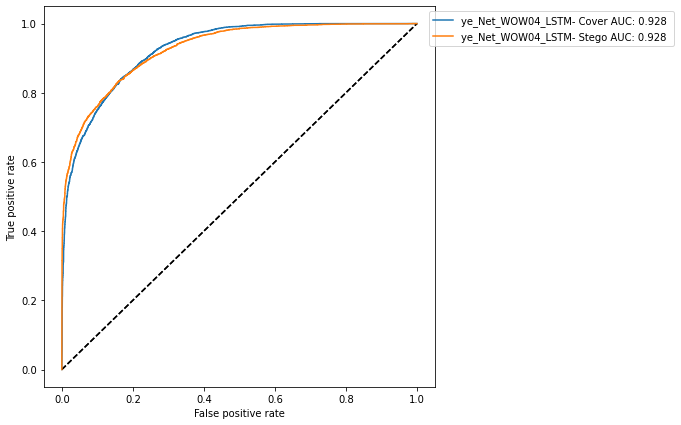

In [ ]:
model= Ye_Net()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Steganalysis/logs/Model_Ye_Net_LSTM2_TPU_04WOW1_Boss/0119.hdf5") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="ye_Net_WOW04_LSTM- "
curve1,labels1=get_curve(y_test, predictions, labels,model_name)